In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

## Assembling the demand data

In [2]:
demand = []
for year in ['09', '10', '11', '12', '13', '14', '15', '16', '17', '18']:
    demand.append(pd.read_csv('demand_2009_2018/PUB_Demand_20' + year + '.csv', skiprows=3))
demand = pd.concat(demand, axis=0, ignore_index=True)
demand.head()

,Date,Hour,Market Demand,Ontario Demand
0,2009-01-01,1,17714,16011
1,2009-01-01,2,17555,15503
2,2009-01-01,3,17228,15095
3,2009-01-01,4,16920,14880
4,2009-01-01,5,16909,14883


In [3]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87648 entries, 0 to 87647
Data columns (total 4 columns):
Date              87648 non-null object
Hour              87648 non-null int64
Market Demand     87648 non-null int64
Ontario Demand    87648 non-null int64
dtypes: int64(3), object(1)
memory usage: 2.7+ MB


In [4]:
demand['Date'] = pd.to_datetime(demand['Date'])

In [5]:
demand = demand[['Date', 'Ontario Demand']].groupby('Date', as_index=False).sum()
demand.columns = ['date', 'demand']
demand['day_of_week'] = demand['date'].dt.weekday_name
demand.head(10)

,date,demand,day_of_week
0,2009-01-01,391706,Thursday
1,2009-01-02,398441,Friday
2,2009-01-03,392559,Saturday
3,2009-01-04,400256,Sunday
4,2009-01-05,429761,Monday
5,2009-01-06,437388,Tuesday
6,2009-01-07,440518,Wednesday
7,2009-01-08,441335,Thursday
8,2009-01-09,447435,Friday
9,2009-01-10,429275,Saturday


In [6]:
demand.groupby('day_of_week', as_index=False).mean()

,day_of_week,demand
0,Friday,385136.308429
1,Monday,386535.061303
2,Saturday,358932.636015
3,Sunday,352580.285441
4,Thursday,391794.314176
5,Tuesday,393207.771593
6,Wednesday,392684.284069


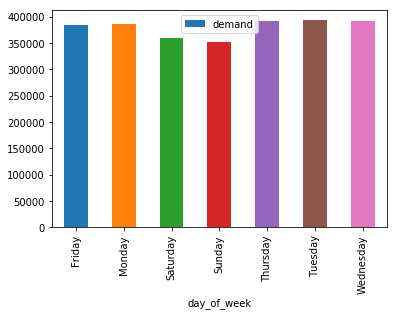

In [7]:
demand.groupby('day_of_week', as_index=False).mean().plot(x='day_of_week', y='demand', kind='bar')

In [8]:
demand = pd.concat([demand.drop('day_of_week', axis=1), pd.get_dummies(demand['day_of_week'])], axis=1)
demand.head(10)

,date,demand,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2009-01-01,391706,0,0,0,0,1,0,0
1,2009-01-02,398441,1,0,0,0,0,0,0
2,2009-01-03,392559,0,0,1,0,0,0,0
3,2009-01-04,400256,0,0,0,1,0,0,0
4,2009-01-05,429761,0,1,0,0,0,0,0
5,2009-01-06,437388,0,0,0,0,0,1,0
6,2009-01-07,440518,0,0,0,0,0,0,1
7,2009-01-08,441335,0,0,0,0,1,0,0
8,2009-01-09,447435,1,0,0,0,0,0,0
9,2009-01-10,429275,0,0,1,0,0,0,0


In [9]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 0 to 3651
Data columns (total 9 columns):
date         3652 non-null datetime64[ns]
demand       3652 non-null int64
Friday       3652 non-null uint8
Monday       3652 non-null uint8
Saturday     3652 non-null uint8
Sunday       3652 non-null uint8
Thursday     3652 non-null uint8
Tuesday      3652 non-null uint8
Wednesday    3652 non-null uint8
dtypes: datetime64[ns](1), int64(1), uint8(7)
memory usage: 110.6 KB


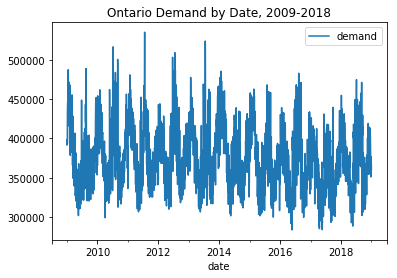

In [10]:
demand.plot(x='date', y='demand', title='Ontario Demand by Date, 2009-2018')

## Filling in the yearly population data
This population data was taken from the Statistics Canada webpage https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=201&SR=1&S=3&O=D&RPP=50&PR=35 with a few caveats. In cases where a region included both an Ontario portion and a Quebec portion, only the Ontario portion was used. Brandford was merged with Kitchener - Cambridge - Waterloo due to there being no better weather station for it than the one used for the latter region. Only regions with a population of over 80,000 were included, which accounts for the vast majority of Ontario's population. Also, finding appropriate weather stations (ones that included daily data for all the years of interest) for the regions with smaller populations proved very problematic.

In [11]:
pop = pd.read_csv('population.csv')
pop.head()

,region,2016,2011,daily_stn,hourly_stn
0,Toronto,5928040,5583064,TORONTO NORTH YORK,TORONTO INTL A
1,Ottawa,991726,936908,OTTAWA CDA,OTTAWA CDA RCS
2,Hamilton,747545,721053,HAMILTON RBG CS,HAMILTON A
3,Kitchener - Cambridge - Waterloo - Brantford,658097,631884,ROSEVILLE,KITCHENER WATERLOO
4,London,494069,474786,LONDON CS,LONDON A


In [12]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 5 columns):
region        17 non-null object
2016          17 non-null int64
2011          17 non-null int64
daily_stn     17 non-null object
hourly_stn    11 non-null object
dtypes: int64(2), object(3)
memory usage: 760.0+ bytes


In [13]:
pop.drop('hourly_stn', axis=1, inplace=True)

Determine average annual population change, with the difference between 2011 and 2016 numbers

In [14]:
pop['change'] = (pop['2016'] - pop['2011']) / 5
pop

,region,2016,2011,daily_stn,change
0,Toronto,5928040,5583064,TORONTO NORTH YORK,68995.2
1,Ottawa,991726,936908,OTTAWA CDA,10963.6
2,Hamilton,747545,721053,HAMILTON RBG CS,5298.4
3,Kitchener - Cambridge - Waterloo - Brantford,658097,631884,ROSEVILLE,5242.6
4,London,494069,474786,LONDON CS,3856.6
5,St. Catharines - Niagara,406074,392184,PORT WELLER (AUT),2778.0
6,Oshawa,379848,356177,OSHAWA WPCP,4734.2
7,Windsor,329144,319246,WINDSOR RIVERSIDE,1979.6
8,Barrie,197059,187013,BARRIE-ORO,2009.2
9,Greater Sudbury,164689,163067,KILLARNEY (AUT),324.4


Some regions' populations have grown, while others have shrunk. Let's interpolate/extrapolate for the surrounding years.

In [15]:
pop['2009'] = pop['2011'] - 2 * pop['change']
pop['2010'] = pop['2011'] - 1 * pop['change']
pop['2012'] = pop['2011'] + 1 * pop['change']
pop['2013'] = pop['2011'] + 2 * pop['change']
pop['2014'] = pop['2016'] - 2 * pop['change']
pop['2015'] = pop['2016'] - 1 * pop['change']
pop['2017'] = pop['2016'] + 1 * pop['change']
pop['2018'] = pop['2016'] + 2 * pop['change']
pop.head()

,region,2016,2011,daily_stn,change,2009,2010,2012,2013,2014,2015,2017,2018
0,Toronto,5928040,5583064,TORONTO NORTH YORK,68995.2,5445073.6,5514068.8,5652059.2,5721054.4,5790049.6,5859044.8,5997035.2,6066030.4
1,Ottawa,991726,936908,OTTAWA CDA,10963.6,914980.8,925944.4,947871.6,958835.2,969798.8,980762.4,1002689.6,1013653.2
2,Hamilton,747545,721053,HAMILTON RBG CS,5298.4,710456.2,715754.6,726351.4,731649.8,736948.2,742246.6,752843.4,758141.8
3,Kitchener - Cambridge - Waterloo - Brantford,658097,631884,ROSEVILLE,5242.6,621398.8,626641.4,637126.6,642369.2,647611.8,652854.4,663339.6,668582.2
4,London,494069,474786,LONDON CS,3856.6,467072.8,470929.4,478642.6,482499.2,486355.8,490212.4,497925.6,501782.2


In [16]:
# Rearrange, leaving out 'change' column, since no further need for it.
pop = pop[['region', 'daily_stn', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']]
pop.set_index('region', inplace=True)
pop

,daily_stn,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
region,,,,,,,,,,,
Toronto,TORONTO NORTH YORK,5445073.6,5514068.8,5583064,5652059.2,5721054.4,5790049.6,5859044.8,5928040,5997035.2,6066030.4
Ottawa,OTTAWA CDA,914980.8,925944.4,936908,947871.6,958835.2,969798.8,980762.4,991726,1002689.6,1013653.2
Hamilton,HAMILTON RBG CS,710456.2,715754.6,721053,726351.4,731649.8,736948.2,742246.6,747545,752843.4,758141.8
Kitchener - Cambridge - Waterloo - Brantford,ROSEVILLE,621398.8,626641.4,631884,637126.6,642369.2,647611.8,652854.4,658097,663339.6,668582.2
London,LONDON CS,467072.8,470929.4,474786,478642.6,482499.2,486355.8,490212.4,494069,497925.6,501782.2
St. Catharines - Niagara,PORT WELLER (AUT),386628.0,389406.0,392184,394962.0,397740.0,400518.0,403296.0,406074,408852.0,411630.0
Oshawa,OSHAWA WPCP,346708.6,351442.8,356177,360911.2,365645.4,370379.6,375113.8,379848,384582.2,389316.4
Windsor,WINDSOR RIVERSIDE,315286.8,317266.4,319246,321225.6,323205.2,325184.8,327164.4,329144,331123.6,333103.2
Barrie,BARRIE-ORO,182994.6,185003.8,187013,189022.2,191031.4,193040.6,195049.8,197059,199068.2,201077.4


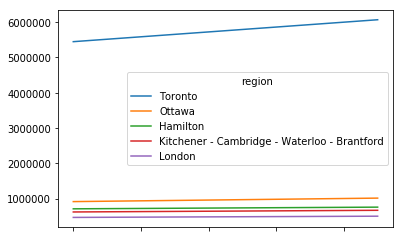

In [17]:
pop.iloc[:5, 1:].T.plot()

The plots are linear as expected.

## Assembling the weather data

The weather data is stored in 10 files (one for each year from 2009 to 2018), in folders (one for each of 17 weather stations) in the weather_daily_2009_2018 folder. We load one file for demonstration and show its properties. Then we load all of the data, select the desired columns and assemble it into our desired features.

In [18]:
# Here is the list of selected Environment and Climate Change Canada weather station names
os.listdir('weather_daily_2009_2018/')

['BARRIE-ORO',
 'BELLEVILLE',
 'CHATHAM WPCP',
 'GUELPH TURFGRASS',
 'HAMILTON RBG CS',
 'KILLARNEY (AUT)',
 'KINGSTON CLIMATE',
 'LONDON CS',
 'OSHAWA WPCP',
 'OTTAWA CDA',
 'PETERBOROUGH TRENT U',
 'PORT WELLER (AUT)',
 'ROSEVILLE',
 'SARNIA CLIMATE',
 'THUNDER BAY CS',
 'TORONTO NORTH YORK',
 'WINDSOR RIVERSIDE']

In [19]:
# Each folder contains files with the same set of names, indicating the date range of contained data for that station.
os.listdir('weather_daily_2009_2018/TORONTO NORTH YORK/')

['eng-daily-01012009-12312009.csv',
 'eng-daily-01012010-12312010.csv',
 'eng-daily-01012011-12312011.csv',
 'eng-daily-01012012-12312012.csv',
 'eng-daily-01012013-12312013.csv',
 'eng-daily-01012014-12312014.csv',
 'eng-daily-01012015-12312015.csv',
 'eng-daily-01012016-12312016.csv',
 'eng-daily-01012017-12312017.csv',
 'eng-daily-01012018-12312018.csv']

In [20]:
temporary = pd.read_csv('weather_daily_2009_2018/TORONTO NORTH YORK/eng-daily-01012009-12312009.csv', skiprows=24)
temporary.head()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2009-01-01,2009,1,1,†,-0.5,NaN,-18.0,NaN,-9.3,...,0.0,T,0.0,T,4,NaN,NaN,NaN,NaN,NaN
1,2009-01-02,2009,1,2,†,1.0,NaN,-7.0,NaN,-3.0,...,1.6,NaN,2.2,NaN,3,NaN,NaN,NaN,NaN,NaN
2,2009-01-03,2009,1,3,†,-3.0,NaN,-8.0,NaN,-5.5,...,0.0,NaN,0.0,NaN,5,NaN,NaN,NaN,NaN,NaN
3,2009-01-04,2009,1,4,†,-1.0,NaN,-15.0,NaN,-8.0,...,0.0,NaN,0.6,NaN,5,NaN,NaN,NaN,NaN,NaN
4,2009-01-05,2009,1,5,†,-1.0,NaN,-5.0,NaN,-3.0,...,0.0,NaN,0.0,NaN,4,NaN,NaN,NaN,NaN,NaN


In [21]:
temporary.tail()

,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
360,2009-12-27,2009,12,27,†,1.5,NaN,-4.0,NaN,-1.3,...,0.0,T,0.0,T,0,T,NaN,NaN,NaN,NaN
361,2009-12-28,2009,12,28,†,-1.5,NaN,-4.0,NaN,-2.8,...,0.4,NaN,0.4,NaN,0,T,NaN,NaN,NaN,NaN
362,2009-12-29,2009,12,29,†,-5.0,NaN,-16.0,NaN,-10.5,...,0.0,T,0.0,T,1,NaN,NaN,NaN,NaN,NaN
363,2009-12-30,2009,12,30,†,0.5,NaN,-8.5,NaN,-4.0,...,0.4,NaN,0.2,NaN,0,T,NaN,NaN,NaN,NaN
364,2009-12-31,2009,12,31,†,2.5,NaN,-5.0,NaN,-1.3,...,0.0,T,1.8,NaN,0,T,NaN,NaN,NaN,NaN


In [22]:
temporary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 27 columns):
Date/Time                    365 non-null object
Year                         365 non-null int64
Month                        365 non-null int64
Day                          365 non-null int64
Data Quality                 365 non-null object
Max Temp (°C)                365 non-null float64
Max Temp Flag                0 non-null float64
Min Temp (°C)                365 non-null float64
Min Temp Flag                0 non-null float64
Mean Temp (°C)               365 non-null float64
Mean Temp Flag               0 non-null float64
Heat Deg Days (°C)           365 non-null float64
Heat Deg Days Flag           0 non-null float64
Cool Deg Days (°C)           365 non-null float64
Cool Deg Days Flag           0 non-null float64
Total Rain (mm)              365 non-null float64
Total Rain Flag              25 non-null object
Total Snow (cm)              365 non-null float64
Total Snow Flag

In [23]:
del temporary

In [24]:
years = []
pref = 'TOR'  # get first 3 letters of station name
for file in sorted(os.listdir('weather_daily_2009_2018/' + 'TORONTO NORTH YORK' + '/')):
    df = pd.read_csv('weather_daily_2009_2018/' + 'TORONTO NORTH YORK' + '/' + file, skiprows=24)
    df = df[['Max Temp (°C)', 'Min Temp (°C)']]
    years.append(df)
years = pd.concat(years, axis=0, ignore_index=True)
years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 2 columns):
Max Temp (°C)    3640 non-null float64
Min Temp (°C)    3640 non-null float64
dtypes: float64(2)
memory usage: 57.1 KB


In [25]:
years[years['Max Temp (°C)'].isna() | years['Min Temp (°C)'].isna()]

,Max Temp (°C),Min Temp (°C)
1714,NaN,NaN
2638,NaN,NaN
2639,NaN,NaN
2640,NaN,NaN
2642,NaN,NaN
2643,NaN,NaN
2660,NaN,NaN
2661,NaN,NaN
3618,NaN,NaN
3619,NaN,NaN


In [26]:
# Need to fill in missing values using linear interpolation
for col in [0, 1]:
    first_nan = True
    for row in range(len(years)):
        if np.isnan(years.iloc[row, col]):
            # Use linear interpolation to fill in missing values
            if first_nan:
                first_nan = False  # Ensures this block is reached only once per gap
                prev = years.iloc[row - 1, col]  # previous value (hopefully no cases of first day missing)
                nex = None  # next non-NaN value, but "next" is a reserved word, so I use nex
                i = 0
                while nex is None:
                    i += 1  # counts missing points
                    maybe = years.iloc[row + i, col]
                    nex = maybe if not np.isnan(maybe) else None
                slope = (nex - prev) / (i + 1)  # slope of line connecting points before and after gap
                point = prev + slope  # next stop along the connecting line
            years.iloc[row, col] = point
            point += slope  # moves along the connecting line for next NaN, if applicable
        else:  # years.iloc[row, col] is not NaN
            first_nan = True  # reset this for next time NaN is encountered

In [27]:
years.iloc[3617:3621]

,Max Temp (°C),Min Temp (°C)
3617,1.500000,-1.000000
3618,1.666667,-0.833333
3619,1.833333,-0.666667
3620,2.000000,-0.500000


Gap has been filled in with linear values.

In [28]:
years.iloc[3622:3626]

,Max Temp (°C),Min Temp (°C)
3622,12.0,1.5
3623,8.5,-2.0
3624,5.0,-5.5
3625,1.5,-9.0


Gap has been filled in with linear values.

In [29]:
years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 2 columns):
Max Temp (°C)    3652 non-null float64
Min Temp (°C)    3652 non-null float64
dtypes: float64(2)
memory usage: 57.1 KB


All gaps have been filled in.

## Engineering our "heat" and "cold" features
#### heat: how many degrees above 22°C the daily maximum is
Above roughly 22°C, thermostats start turning on indoor air conditioning, a major consumer of power.
#### cold: how many degrees below 20°C the daily minimum is
Below roughly 20°C, thermostats start turning on indoor heating, some of which is electric. There are other uses of electricity that can be expected in increase in response to cold, such as people plugging in vehicle engine block heaters to preserve car batteries.

In [30]:
years['TOR' + '_heat'] = years['Max Temp (°C)'].apply(lambda x: max(0, x - 22))
years['TOR' + '_cold'] = years['Min Temp (°C)'].apply(lambda x: max(0, 20 - x))

In [31]:
# The first 5 days of January 2009
years.head()

,Max Temp (°C),Min Temp (°C),TOR_heat,TOR_cold
0,-0.5,-18.0,0.0,38.0
1,1.0,-7.0,0.0,27.0
2,-3.0,-8.0,0.0,28.0
3,-1.0,-15.0,0.0,35.0
4,-1.0,-5.0,0.0,25.0


In [32]:
# Some summer days in 2009
years.iloc[180:200]

,Max Temp (°C),Min Temp (°C),TOR_heat,TOR_cold
180,21.5,15.5,0.0,4.5
181,23.5,15.0,1.5,5.0
182,23.0,15.5,1.0,4.5
183,23.5,16.0,1.5,4.0
184,22.5,13.0,0.5,7.0
185,24.5,7.0,2.5,13.0
186,24.0,11.5,2.0,8.5
187,20.5,13.0,0.0,7.0
188,24.5,12.5,2.5,7.5
189,25.5,11.5,3.5,8.5


In [33]:
years.describe()

,Max Temp (°C),Min Temp (°C),TOR_heat,TOR_cold
count,3652.000000,3652.000000,3652.000000,3652.000000
mean,13.838130,4.039294,1.587829,16.007667
std,11.556251,10.175959,2.917161,10.095765
min,-19.000000,-26.500000,0.000000,0.000000
25%,4.000000,-3.000000,0.000000,7.500000
50%,14.500000,4.000000,0.000000,16.000000
75%,24.000000,12.500000,2.000000,23.000000
max,36.500000,26.500000,14.500000,46.500000


## Assembling data for all stations
Now we will assemble a dataset for all stations, built on the process demonstrated for the TORONTO NORTH YORK station. I have decided that for the moment I will leave the population variables out of the feature set because the ML models should come up with their own appropriate variable weights, It will prove interesting to compare these weights against the regional populations. I hope the temperatures of more populous regions will be of more importance in predicting the emergy demand.

In [34]:
import time
start = time.time()
stations = []
for station in pop['daily_stn']:
    years = []
    for file in sorted(os.listdir('weather_daily_2009_2018/' + station + '/')):
        df = pd.read_csv('weather_daily_2009_2018/' + station + '/' + file, skiprows=24)
        df = df[['Max Temp (°C)', 'Min Temp (°C)']]
        years.append(df)
    years = pd.concat(years, axis=0, ignore_index=True)
    # Need to fill in missing values using linear interpolation
    for col in [0, 1]:
        first_nan = True
        for row in range(len(years)):
            if np.isnan(years.iloc[row, col]):
                # Missing value(s) to be filled in
                if first_nan:
                    first_nan = False  # Ensures this block is reached only once per gap
                    prev = years.iloc[row - 1, col]  # previous value (hopefully no cases of first day missing)
                    nex = None  # next non-NaN value, but "next" is a reserved word, so I use nex
                    i = 0
                    while nex is None:
                        i += 1  # counts missing points
                        if row + i <= 3651:  # To keep the index in bounds
                            maybe = years.iloc[row + i, col]
                            nex = maybe if not np.isnan(maybe) else None
                        else:
                            print(station)
                            nex = prev
                    slope = (nex - prev) / (i + 1)  # slope of line connecting points before and after gap
                    point = prev + slope  # next stop along the connecting line
                years.iloc[row, col] = point
                point += slope  # moves along the connecting line for next NaN, if applicable
            else:  # years.iloc[row, col] is not NaN
                first_nan = True  # reset this for next time NaN is encountered
    pref = station[0:3]  # get first 3 letters of station name
    years[pref + '_heat'] = years['Max Temp (°C)'].apply(lambda x: max(0, x - 22))  # Measure of max > 22°C
    years[pref + '_cold'] = years['Min Temp (°C)'].apply(lambda x: max(0, 20 - x))  # Measure of min < 20°C
    years.drop(['Max Temp (°C)','Min Temp (°C)'], axis=1, inplace=True)
    stations.append(years)
print('Run took {} seconds'.format(round(time.time() - start, 2)))
len(stations)

CHATHAM WPCP
CHATHAM WPCP
Run took 5.42 seconds


17

In [35]:
data = pd.concat([demand] + stations, axis=1)

In [36]:
data.head()

,date,demand,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,TOR_heat,...,PET_heat,PET_cold,THU_heat,THU_cold,BEL_heat,BEL_cold,CHA_heat,CHA_cold,SAR_heat,SAR_cold
0,2009-01-01,391706,0,0,0,0,1,0,0,0.0,...,0.0,42.6,0.0,41.2,0.0,38.0,0.0,32.000000,0.0,34.3
1,2009-01-02,398441,1,0,0,0,0,0,0,0.0,...,0.0,28.1,0.0,44.8,0.0,30.0,0.0,30.000000,0.0,28.3
2,2009-01-03,392559,0,0,1,0,0,0,0,0.0,...,0.0,33.0,0.0,46.5,0.0,29.5,0.0,28.666667,0.0,31.6
3,2009-01-04,400256,0,0,0,1,0,0,0,0.0,...,0.0,36.9,0.0,42.1,0.0,35.0,0.0,27.333333,0.0,28.3
4,2009-01-05,429761,0,1,0,0,0,0,0,0.0,...,0.0,30.4,0.0,52.2,0.0,27.0,0.0,26.000000,0.0,28.6


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 0 to 3651
Data columns (total 43 columns):
date         3652 non-null datetime64[ns]
demand       3652 non-null int64
Friday       3652 non-null uint8
Monday       3652 non-null uint8
Saturday     3652 non-null uint8
Sunday       3652 non-null uint8
Thursday     3652 non-null uint8
Tuesday      3652 non-null uint8
Wednesday    3652 non-null uint8
TOR_heat     3652 non-null float64
TOR_cold     3652 non-null float64
OTT_heat     3652 non-null float64
OTT_cold     3652 non-null float64
HAM_heat     3652 non-null float64
HAM_cold     3652 non-null float64
ROS_heat     3652 non-null float64
ROS_cold     3652 non-null float64
LON_heat     3652 non-null float64
LON_cold     3652 non-null float64
POR_heat     3652 non-null float64
POR_cold     3652 non-null float64
OSH_heat     3652 non-null float64
OSH_cold     3652 non-null float64
WIN_heat     3652 non-null float64
WIN_cold     3652 non-null float64
BAR_heat     3652 non-null 

43 columns with no missing data!

Let's look at their basic summary stats.

In [38]:
data.describe().iloc[:, :10]

,demand,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,TOR_heat,TOR_cold
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,380117.358434,0.142935,0.142935,0.142935,0.142935,0.142935,0.142662,0.142662,1.587829,16.007667
std,38925.389696,0.350055,0.350055,0.350055,0.350055,0.350055,0.349775,0.349775,2.917161,10.095765
min,283341.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,353720.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.500000
50%,376296.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.000000
75%,406793.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,23.000000
max,535528.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,46.500000


In [39]:
data.describe().iloc[:, 10:20]

,OTT_heat,OTT_cold,HAM_heat,HAM_cold,ROS_heat,ROS_cold,LON_heat,LON_cold,POR_heat,POR_cold
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,1.383406,17.435967,1.496906,15.955326,1.229121,16.821947,1.348446,16.429231,1.066895,13.415649
std,2.671318,11.534504,2.872793,9.501810,2.416453,10.150467,2.526167,10.071576,2.266493,9.206752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.500000,0.000000,8.200000,0.000000,8.000000,0.000000,7.875000,0.000000,4.900000
50%,0.000000,16.500000,0.000000,15.500000,0.000000,17.000000,0.000000,16.300000,0.000000,13.700000
75%,1.500000,25.100000,1.700000,22.300000,1.000000,23.500000,1.700000,23.300000,0.400000,20.100000
max,14.300000,51.000000,16.100000,47.300000,13.000000,52.000000,14.700000,48.800000,12.000000,41.200000


In [40]:
data.describe().iloc[:, 20:30]

,OSH_heat,OSH_cold,WIN_heat,WIN_cold,BAR_heat,BAR_cold,KIL_heat,KIL_cold,KIN_heat,KIN_cold
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,0.963513,15.808434,2.160515,13.771974,1.007735,19.001369,0.264808,17.167032,0.836120,16.994359
std,2.052950,10.119945,3.489261,9.904976,2.164695,10.824385,0.937823,11.195463,1.820663,10.674390
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.395455,0.000000,5.000000,0.000000,10.200000,0.000000,7.500000,0.000000,8.100000
50%,0.000000,15.000000,0.000000,13.500000,0.000000,18.300000,0.000000,16.200000,0.000000,16.400000
75%,0.406250,22.000000,4.000000,21.308333,0.400000,25.400000,0.000000,24.700000,0.000000,23.900000
max,15.500000,47.000000,16.500000,45.000000,11.800000,55.300000,9.500000,49.500000,11.700000,52.800000


In [41]:
data.describe().iloc[:, 30:40]

,GUE_heat,GUE_cold,PET_heat,PET_cold,THU_heat,THU_cold,BEL_heat,BEL_cold,CHA_heat,CHA_cold
count,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000,3652.000000
mean,1.127962,18.408242,1.328049,18.992237,0.745824,22.837349,1.297747,16.641279,1.443999,14.158165
std,2.321443,9.900811,2.577594,10.701716,1.884825,12.136073,2.498486,10.641959,2.614120,10.028199
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.400000,0.000000,10.300000,0.000000,12.700000,0.000000,7.703125,0.000000,5.196000
50%,0.000000,18.100000,0.000000,18.400000,0.000000,21.500000,0.000000,16.500000,0.000000,13.333333
75%,0.735401,24.800000,1.400000,25.700000,0.000000,30.800000,1.500000,23.500000,2.154167,21.000000
max,12.700000,52.700000,13.700000,51.300000,11.400000,59.600000,14.000000,53.000000,15.000000,46.500000


In [42]:
data.describe().iloc[:, 40:50]

,SAR_heat,SAR_cold
count,3652.000000,3652.000000
mean,1.431996,15.838157
std,2.762713,9.866377
min,0.000000,0.000000
25%,0.000000,7.400000
50%,0.000000,15.900000
75%,1.600000,22.800000
max,14.700000,48.300000


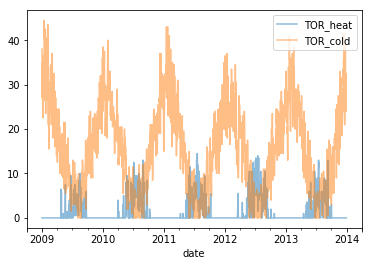

In [43]:
# As a sanity check, let's plot one station's heat and cold features for the first 5 years.
data.iloc[:int(0.5*len(data))].plot(x='date', y=['TOR_heat', 'TOR_cold'], alpha=0.5)

In [44]:
# Save assembled data to file for easy loading later
data.to_csv('engineered.csv', index=False)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 0 to 3651
Data columns (total 43 columns):
date         3652 non-null datetime64[ns]
demand       3652 non-null int64
Friday       3652 non-null uint8
Monday       3652 non-null uint8
Saturday     3652 non-null uint8
Sunday       3652 non-null uint8
Thursday     3652 non-null uint8
Tuesday      3652 non-null uint8
Wednesday    3652 non-null uint8
TOR_heat     3652 non-null float64
TOR_cold     3652 non-null float64
OTT_heat     3652 non-null float64
OTT_cold     3652 non-null float64
HAM_heat     3652 non-null float64
HAM_cold     3652 non-null float64
ROS_heat     3652 non-null float64
ROS_cold     3652 non-null float64
LON_heat     3652 non-null float64
LON_cold     3652 non-null float64
POR_heat     3652 non-null float64
POR_cold     3652 non-null float64
OSH_heat     3652 non-null float64
OSH_cold     3652 non-null float64
WIN_heat     3652 non-null float64
WIN_cold     3652 non-null float64
BAR_heat     3652 non-null 

## Correlations

In [46]:
# Let's look at correlations for the weather stations in the 5 most populous regions.
data.iloc[:, [1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]].corr()

,demand,TOR_heat,TOR_cold,OTT_heat,OTT_cold,HAM_heat,HAM_cold,ROS_heat,ROS_cold,LON_heat,LON_cold
demand,1.000000,0.349013,0.198259,0.333118,0.242646,0.360916,0.188289,0.340742,0.229255,0.352853,0.213525
TOR_heat,0.349013,1.000000,-0.634883,0.896440,-0.610630,0.946195,-0.644535,0.924317,-0.616956,0.943822,-0.640145
TOR_cold,0.198259,-0.634883,1.000000,-0.601629,0.958101,-0.616161,0.950307,-0.588769,0.975946,-0.622552,0.962699
OTT_heat,0.333118,0.896440,-0.601629,1.000000,-0.585127,0.844584,-0.606783,0.840642,-0.582402,0.855320,-0.605343
OTT_cold,0.242646,-0.610630,0.958101,-0.585127,1.000000,-0.591557,0.912573,-0.564564,0.939876,-0.594634,0.924675
HAM_heat,0.360916,0.946195,-0.616161,0.844584,-0.591557,1.000000,-0.626354,0.883804,-0.596059,0.910507,-0.613186
HAM_cold,0.188289,-0.644535,0.950307,-0.606783,0.912573,-0.626354,1.000000,-0.596571,0.946537,-0.633541,0.958993
ROS_heat,0.340742,0.924317,-0.588769,0.840642,-0.564564,0.883804,-0.596571,1.000000,-0.582868,0.935765,-0.599734
ROS_cold,0.229255,-0.616956,0.975946,-0.582402,0.939876,-0.596059,0.946537,-0.582868,1.000000,-0.608611,0.965166
LON_heat,0.352853,0.943822,-0.622552,0.855320,-0.594634,0.910507,-0.633541,0.935765,-0.608611,1.000000,-0.635708


The above correlation table shows several things of note.

1) There is some degree of positive correlation between demand and every shown heat and cold feature, which is what I had hoped. However, these are only about 0.35 for heat features and about 0.2 for cold features.

2) The heat-demand correlations are all higher than the cold-demand correlations, suggesting that hot weather (air conditioning) has a bigger influence on demand than cold weather (electric heating).

3) There is a very high positive correlation (~0.9-0.95) between each of the heat features, which makes sense since the weather stations are all in the same province. Likewise between each of the cold features.

4) The correlations between the heat and cold features are all around -0.6, which makes sense since there is often some overlap between positive heat (from daytime highs) and positive cold (from nighttime lows).